In [1]:
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras import layers
#from keras.preprocessing import image
from keras.utils import to_categorical
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

%matplotlib inline

Using TensorFlow backend.


In [2]:
id_breed = pd.read_csv('./labels.csv', index_col='id').breed
breed_index = {}
index_breed = {}
x_train = []
y_train = []

train_path = os.path.join('./train')
for img_name in os.listdir(train_path):
    img_id = img_name[:-4]
    breed = id_breed.get(img_id)
    if breed is not None:
        img = cv2.resize(cv2.imread(os.path.join(train_path, img_name)), dsize=(150, 150))
        if breed not in breed_index:
            index = len(breed_index)
            breed_index[breed] = index
            index_breed[index] = breed
        x_train.append(img)
        y_train.append(breed_index[breed])
    
x_train = np.asarray(x_train, dtype=np.float32) / 255.
y_train = to_categorical(np.asarray(y_train))

indices = np.arange(x_train.shape[0])
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]

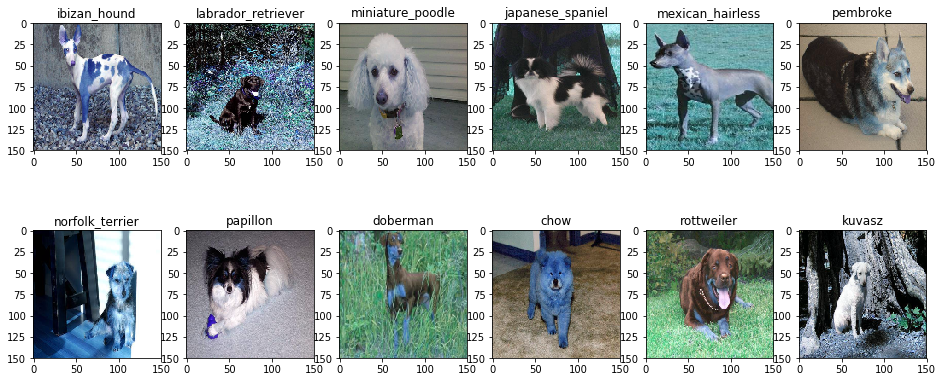

In [10]:
plt.figure(figsize=(16, 7))
for i in range(12):
    plt.subplot(2,6,i+1)
    plt.title(index_breed[np.argmax(y_train[i])])
    plt.imshow(x_train[i])
plt.show()

In [16]:
input_tensor = layers.Input(shape=(150, 150, 3))
base_model = InceptionV3(include_top=False, weights='imagenet', input_tensor=input_tensor)
x = base_model.output
x = layers.GlobalMaxPooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
preds = layers.Dense(120, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=preds)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_283 (Conv2D)             (None, 74, 74, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_283 (BatchN (None, 74, 74, 32)   96          conv2d_283[0][0]                 
__________________________________________________________________________________________________
activation_283 (Activation)     (None, 74, 74, 32)   0           batch_normalization_283[0][0]    
__________________________________________________________________________________________________
conv2d_284

In [17]:
model.fit(x_train, y_train, epochs=1, batch_size=64, validation_split=0.1)
model.save('model.h5')

Train on 9199 samples, validate on 1023 samples
Epoch 1/1
9199/9199 [==============================] - 1714s 186ms/step - loss: 4.7231 - acc: 0.0563 - val_loss: 4.2774 - val_acc: 0.2023


In [3]:
from keras.models import load_model

model = load_model('model.h5')
x_test = []
img_ids = []

test_path = os.path.join('./test')
for img_name in os.listdir(test_path):    
    img = cv2.resize(cv2.imread(os.path.join(test_path, img_name)), dsize=(150, 150))    
    x_test.append(img)
    img_ids.append(img_name[:-4])
    
x_test = np.asarray(x_test, dtype=np.float32) / 255.
preds = model.predict(x_test, batch_size=64)

NameError: name 'index_breed' is not defined

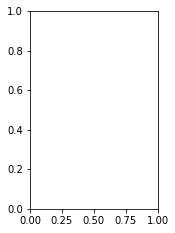

In [5]:
plt.figure(figsize=(16, 8))
for i in range(12):
    plt.subplot(2,6,i+1)
    plt.title(index_breed[np.argmax(preds[i])])
    plt.imshow(x_test[i])
plt.show()

In [ ]:
preds_df = pd.DataFrame(preds, columns=[index_breed[i] for i in range(120)])
preds_df.to_csv('submission.csv')